<a href="https://colab.research.google.com/github/Paaaark/Kaggle/blob/main/titanic/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn import model_selection
import csv
from tabulate import tabulate

In [37]:
%run /content/drive/MyDrive/Kaggle/titanic/helper.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/titanic/train.csv')
df.head()
COLUMNS = ['Pclass', 'Sex', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'FareBin', 'AgeBin']
trained_models = {}

# TensorFlow Deep Neural Network

<ipython-input-3-eb6c331e4a2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


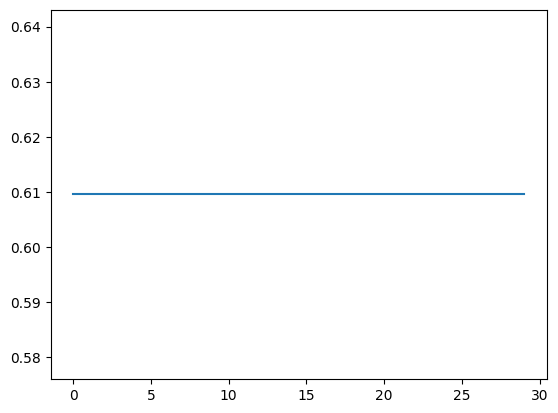

In [18]:
train_x, train_y = process_and_engineer_data(df, columns=COLUMNS)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=8, activation='relu', input_shape=[8,]))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
hist = model.fit(train_x, train_y, epochs=30, verbose=False,
                 validation_split=0.2)
plt.plot(hist.history['acc'])
plt.show()

# Scikit-learn Models Benchmark

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = [RandomForestClassifier(max_depth=2, random_state=0),
          DecisionTreeClassifier(random_state=0),
          GaussianNB(),
          KNeighborsClassifier(n_neighbors=5),
          SVC(gamma='auto'),
          MLPClassifier(random_state=1, max_iter=500, solver='lbfgs', early_stopping=True)]
model_names = ['Random Forest', 'Decision Tree', 'GaussianNB', 'K-Neighbors',
               'SVM', 'Neural Network']

train_x, test_x, train_y, test_y = process_and_engineer_data(df, split_rate=0.2, columns=COLUMNS)
for model, model_name in zip(models, model_names):
  model = model.fit(train_x, train_y)
  trained_models[model_name] = model
  print(model_name)
  print("Train Acc: ", model.score(train_x, train_y))
  print("Test Acc: ", model.score(test_x, test_y))

<ipython-input-3-eb6c331e4a2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


Random Forest
Train Acc:  0.8132022471910112
Test Acc:  0.8044692737430168
Decision Tree
Train Acc:  0.8862359550561798
Test Acc:  0.8044692737430168
GaussianNB
Train Acc:  0.7907303370786517
Test Acc:  0.7988826815642458
K-Neighbors
Train Acc:  0.8469101123595506
Test Acc:  0.8435754189944135
SVM
Train Acc:  0.8412921348314607
Test Acc:  0.8212290502793296
Neural Network
Train Acc:  0.8567415730337079
Test Acc:  0.8044692737430168


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [41]:
train_x, test_x, train_y, test_y = process_and_engineer_data(df, split_rate=0.2, columns=COLUMNS)
for n in range(2, 16):
  model = KNeighborsClassifier(n_neighbors=n)
  model = model.fit(train_x, train_y)
  trained_models['KNN,N=' + str(n)] = model
  print(n)
  print("Train Acc: ", model.score(train_x, train_y))
  print("Test Acc: ", model.score(test_x, test_y))

<ipython-input-37-7ca4cb34ae7d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


2
Train Acc:  0.8398876404494382
Test Acc:  0.8212290502793296
3
Train Acc:  0.827247191011236
Test Acc:  0.8044692737430168
4
Train Acc:  0.8412921348314607
Test Acc:  0.8379888268156425
5
Train Acc:  0.8469101123595506
Test Acc:  0.8435754189944135
6
Train Acc:  0.8384831460674157
Test Acc:  0.8100558659217877
7
Train Acc:  0.8426966292134831
Test Acc:  0.8100558659217877
8
Train Acc:  0.8356741573033708
Test Acc:  0.8100558659217877
9
Train Acc:  0.8300561797752809
Test Acc:  0.8100558659217877
10
Train Acc:  0.827247191011236
Test Acc:  0.8100558659217877
11
Train Acc:  0.8286516853932584
Test Acc:  0.8044692737430168
12
Train Acc:  0.8314606741573034
Test Acc:  0.7988826815642458
13
Train Acc:  0.8342696629213483
Test Acc:  0.7877094972067039
14
Train Acc:  0.8314606741573034
Test Acc:  0.8100558659217877
15
Train Acc:  0.8286516853932584
Test Acc:  0.8044692737430168


# Decision Tree Models Benchmark

<ipython-input-3-eb6c331e4a2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0
<ipython-input-3-eb6c331e4a2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


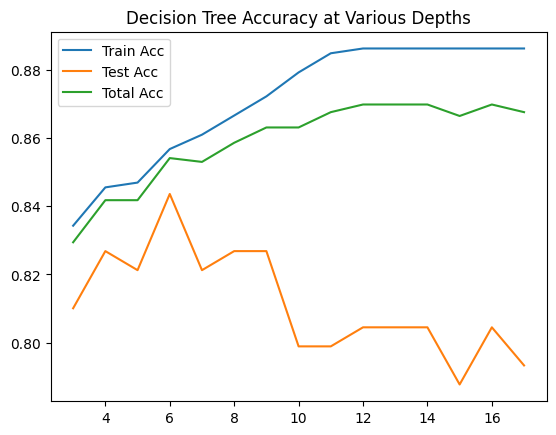

In [22]:
train_x, test_x, train_y, test_y = process_and_engineer_data(df, split_rate=0.2, columns=COLUMNS)
x, y = process_and_engineer_data(df, columns=COLUMNS)
options = ["gini"]
test_acc = []
train_acc = []
total_acc = []
my_range = range(3, 18, 1)
for i in my_range:
  model = DecisionTreeClassifier(max_depth=i)
  model = model.fit(train_x, train_y)
  test_acc.append(model.score(test_x, test_y))
  train_acc.append(model.score(train_x, train_y))
  total_acc.append(model.score(x, y))
plt.plot(my_range, train_acc)
plt.plot(my_range, test_acc)
plt.plot(my_range, total_acc)
plt.title("Decision Tree Accuracy at Various Depths")
plt.legend(['Train Acc', 'Test Acc', 'Total Acc'])

<ipython-input-3-eb6c331e4a2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0
<ipython-input-3-eb6c331e4a2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


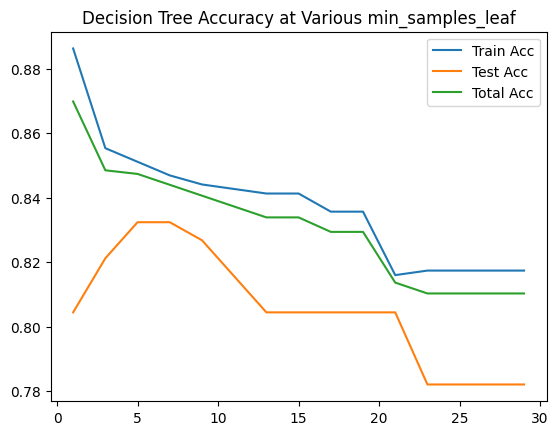

In [23]:
train_x, test_x, train_y, test_y = process_and_engineer_data(df, split_rate=0.2, columns=COLUMNS)
x, y = process_and_engineer_data(df, columns=COLUMNS)
options = ["gini"]
test_acc = []
train_acc = []
total_acc = []
my_range = range(1, 30, 2)
for i in my_range:
  model = DecisionTreeClassifier(min_samples_leaf=i)
  model = model.fit(train_x, train_y)
  test_acc.append(model.score(test_x, test_y))
  train_acc.append(model.score(train_x, train_y))
  total_acc.append(model.score(x, y))
plt.plot(my_range, train_acc)
plt.plot(my_range, test_acc)
plt.plot(my_range, total_acc)
plt.title("Decision Tree Accuracy at Various min_samples_leaf")
plt.legend(['Train Acc', 'Test Acc', 'Total Acc'])

In [47]:
train_x, test_x, train_y, test_y = process_and_engineer_data(df, split_rate=0.2, columns=COLUMNS)
x, y = process_and_engineer_data(df, columns=COLUMNS)
options = ["gini"]
acc = {}
depth_range = range(3, 17, 1)
leaf_range = range(1, 10, 1)
for depth in depth_range:
  for leaf in leaf_range:
    model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
    model = model.fit(train_x, train_y)
    scores = [model.score(train_x, train_y), model.score(test_x, test_y),
              model.score(x, y)]
    key = '(' + str(depth) + ', ' + str(leaf) + ')'
    acc[key] = scores
    trained_models[key] = model
acc = sorted(acc.items(), key=lambda x:x[1][2], reverse=True)
to_table = []
for data in acc:
  to_table.append([data[0], data[1][0], data[1][1], data[1][2]])
print("Decision Tree Accuracy at Various max_depth and min_samples_leaf")
print("Sorted by high to low accuracy")
print(tabulate(to_table, headers=['(depth, leaf)', 'train_acc', 'test_acc', 'acc']))
# plt.plot(my_range, train_acc)
# plt.plot(my_range, test_acc)
# plt.plot(my_range, total_acc)
# plt.title("Decision Tree Accuracy at Various min_samples_leaf")
# plt.legend(['Train Acc', 'Test Acc', 'Total Acc'])

<ipython-input-37-7ca4cb34ae7d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0
<ipython-input-37-7ca4cb34ae7d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


Decision Tree Accuracy at Various max_depth and min_samples_leaf
Sorted by high to low accuracy
(depth, leaf)      train_acc    test_acc       acc
---------------  -----------  ----------  --------
(13, 1)             0.886236    0.804469  0.869809
(14, 1)             0.886236    0.804469  0.869809
(15, 1)             0.886236    0.804469  0.869809
(16, 1)             0.886236    0.793296  0.867565
(12, 1)             0.886236    0.787709  0.866442
(10, 1)             0.879213    0.804469  0.864198
(11, 1)             0.884831    0.776536  0.863075
(9, 1)              0.872191    0.815642  0.860831
(8, 1)              0.866573    0.821229  0.857464
(6, 1)              0.856742    0.843575  0.854097
(7, 1)              0.860955    0.821229  0.852974
(7, 2)              0.852528    0.843575  0.85073
(10, 2)             0.858146    0.815642  0.849607
(11, 2)             0.858146    0.815642  0.849607
(12, 2)             0.858146    0.815642  0.849607
(13, 2)             0.858146    0.8156

# Manual Decision Tree

From 5 categorical data, get every unique combinations. For each combination, count the number of survived and dead.
Predict any person with such combination to survived if more of that category survived, otherwise dead.

In [ ]:
X, y = process_data(df, drop_columns=['Embarked'])

def get_key(my_list):
  result = ""
  for i in range(len(my_list) - 1):
    result = result + str(int(my_list[i]))
  fare = str(int(round(my_list[len(my_list) - 1] + 1, 1) * 10))
  if len(fare) == 1:
    fare = '0' + fare
  result = result + fare
  return result

unique = {}
for i in range(len(X)):
  key = get_key(X[i].numpy().tolist())
  if key in unique.keys():
    unique[key][y[i]] += 1
  else:
    unique[key] = [0, 0]
    unique[key][y[i]] += 1

score = [0, 0]
answer_key = {}
for key in unique.keys():
  correct = max(unique[key])
  wrong = min(unique[key])
  score[0] += correct
  score[1] += wrong
  if unique[key][0] > unique[key][1]:
    answer_key[key] = 0
  else:
    answer_key[key] = 1
print(score)
print(answer_key)

[770, 121]
{'301003': 0, '111026': 1, '310003': 1, '111020': 1, '300003': 0, '100019': 0, '303108': 0, '310204': 1, '211011': 1, '311106': 0, '110010': 1, '301512': 0, '210006': 1, '304111': 0, '200005': 0, '311007': 0, '200010': 0, '100013': 0, '313108': 0, '311512': 1, '103237': 0, '100010': 0, '111037': 1, '200004': 0, '101030': 0, '101019': 1, '312007': 0, '311004': 0, '211008': 0, '211215': 1, '301006': 0, '302008': 0, '304115': 0, '111028': 1, '211010': 1, '100123': 0, '210004': 1, '211210': 1, '305217': 0, '110029': 1, '101031': 0, '303210': 0, '301106': 1, '314203': 1, '302003': 0, '315217': 0, '200027': 0, '301005': 0, '300021': 1, '200211': 1, '310005': 1, '300004': 0, '100017': 0, '313006': 1, '301313': 0, '113237': 1, '101023': 0, '301208': 1, '210109': 1, '201010': 0, '100128': 0, '311009': 1, '311005': 0, '201008': 0, '100137': 0, '314212': 0, '202027': 0, '201011': 0, '210005': 1, '301004': 1, '311108': 1, '200006': 0, '110210': 1, '101020': 1, '100029': 0, '310206': 1, 

In [ ]:
# Test the data using the algorithm above
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle/titanic/test.csv')

test = process_data(test_df, drop_columns=['Embarked'])
ans = []
for i in range(len(test)):
  key = get_key(test[i].numpy().tolist())
  if key not in answer_key:
    counter = 1
    while True:
      left = str(int(key) - counter)
      right = str(int(key) + counter)
      if left in answer_key:
        key = left
        break
      if right in answer_key:
        key = right
        break
      counter += 1
  ans.append(answer_key[key])

print(len(ans))
write_prediction(ans, 'ManualTreeWithFare')

418


In [ ]:
from sklearn.decomposition import PCA
train_x, test_x, train_y, test_y = process_data(df, 0.2)

pca = PCA()
pca.fit(train_x)
print(pca.explained_variance_ratio_)
print(train_x)

[0.41031488 0.27965333 0.1153202  0.10511885 0.04941706 0.04017568]
tf.Tensor(
[[ 3.          0.          0.          0.         -0.70621053  2.        ]
 [ 2.          0.          0.          0.         -0.53769158  2.        ]
 [ 3.          0.          0.          0.         -0.7065146   2.        ]
 ...
 [ 3.          0.          0.          0.         -0.70621053  2.        ]
 [ 2.          0.          1.          1.         -0.03762989  0.        ]
 [ 1.          1.          1.          1.          2.67332724  0.        ]], shape=(712, 6), dtype=float64)


In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate

train_x, test_x, train_y, test_y = process_data(df, split_rate=0.2)
# print(train_x)
model = DecisionTreeClassifier(max_depth=10)
# model = model.fit(train_x, train_y)
models = cross_validate(model, train_x, train_y)

In [49]:
trained_models.keys()

dict_keys(['Random Forest', 'Decision Tree', 'GaussianNB', 'K-Neighbors', 'SVM', 'Neural Network', ('KNN,N=', '2'), ('KNN,N=', '3'), ('KNN,N=', '4'), ('KNN,N=', '5'), ('KNN,N=', '6'), ('KNN,N=', '7'), ('KNN,N=', '8'), ('KNN,N=', '9'), ('KNN,N=', '10'), ('KNN,N=', '11'), ('KNN,N=', '12'), ('KNN,N=', '13'), ('KNN,N=', '14'), ('KNN,N=', '15'), 'KNN,N=2', 'KNN,N=3', 'KNN,N=4', 'KNN,N=5', 'KNN,N=6', 'KNN,N=7', 'KNN,N=8', 'KNN,N=9', 'KNN,N=10', 'KNN,N=11', 'KNN,N=12', 'KNN,N=13', 'KNN,N=14', 'KNN,N=15', '(3, 1)', '(3, 2)', '(3, 3)', '(3, 4)', '(3, 5)', '(3, 6)', '(3, 7)', '(3, 8)', '(3, 9)', '(4, 1)', '(4, 2)', '(4, 3)', '(4, 4)', '(4, 5)', '(4, 6)', '(4, 7)', '(4, 8)', '(4, 9)', '(5, 1)', '(5, 2)', '(5, 3)', '(5, 4)', '(5, 5)', '(5, 6)', '(5, 7)', '(5, 8)', '(5, 9)', '(6, 1)', '(6, 2)', '(6, 3)', '(6, 4)', '(6, 5)', '(6, 6)', '(6, 7)', '(6, 8)', '(6, 9)', '(7, 1)', '(7, 2)', '(7, 3)', '(7, 4)', '(7, 5)', '(7, 6)', '(7, 7)', '(7, 8)', '(7, 9)', '(8, 1)', '(8, 2)', '(8, 3)', '(8, 4)', '(8, 5)

In [51]:
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle/titanic/test.csv')

test, y = process_and_engineer_data(test_df, columns=COLUMNS)
desired_model = trained_models['KNN,N=4']
prediction = desired_model.predict(test)
print(prediction)
write_prediction(prediction, 'KNN,N=4')

<ipython-input-37-7ca4cb34ae7d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


[0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0
 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1
 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1 0
 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1
 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0
 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1
 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1
 1 1 1 1 1 0 0 0 0 0 0]
